## Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. 

Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре

default - индикатор невозврата денежных средств

#### Импортируем библиотеки и загрузим данные

In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt

In [4]:
scoring = pd.read_csv('credit_card_default_analysis.csv')
scoring.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Задание

## 1.
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [5]:
# Приготовим две выборки тех кто вернул кредит и тех кто не вернул кредит
Vernul = scoring[scoring['default'] == 0].LIMIT_BAL.values
NeVernul = scoring[scoring['default'] == 1].LIMIT_BAL.values

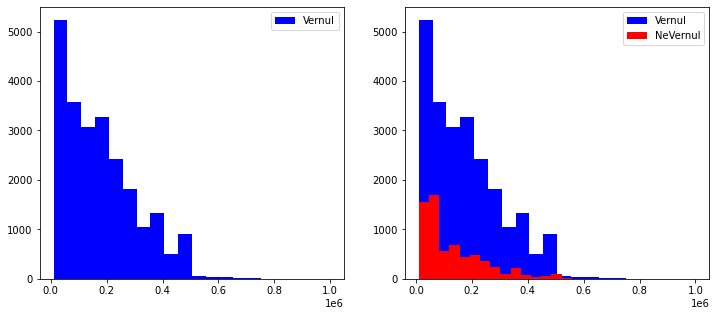

In [7]:
plt.figure(figsize(12, 5))
plt.subplot(1,2,1)
plt.hist(scoring[scoring['default'] == 0].LIMIT_BAL, bins = 20, color = 'b', label = 'Vernul')
plt.legend()

plt.subplot(1,2,2)
plt.hist(scoring[scoring['default'] == 0].LIMIT_BAL, bins = 20, color = 'b', label = 'Vernul')
plt.hist(scoring[scoring['default'] == 1].LIMIT_BAL, bins = 20, color = 'r', label = 'NeVernul')
plt.legend()

plt.show()

Как видно из графиков, в невозвратные кредиты как правило попадают кредиты на меньшие суммы чем те, которые вернули

Для проверки гипотезы о равенстве медианных значений используем интервальную оценку на основе бутстрепа

* H0: медианные значения равны
* H1: медианные значения отличаются

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

Vernul_median_scores = list(map(np.median, get_bootstrap_samples(Vernul, 1000)))
NeVernul_median_scores = list(map(np.median, get_bootstrap_samples(NeVernul, 1000)))

print("95% доверительный итервал медианного значение кредитного лимита для вернувших кредит:",  stat_intervals(Vernul_median_scores, 0.05))
print("95% доверительный итервал медианного значение кредитного лимита для невернувших кредит:",  stat_intervals(NeVernul_median_scores, 0.05))

95% доверительный итервал медианного значение кредитного лимита для вернувших кредит: [150000. 150000.]
95% доверительный итервал медианного значение кредитного лимита для невернувших кредит: [80000. 90000.]


Как видно из интервальной оценки, медианы не совпадают. Заёмщики, которые не возвращают кредит, обычно берут меньшую сумму.

Для проверки гипотезы о равенстве распределений подойдёт перестановочный критерий для независимых выборок.

H0: распределения выборок полностью равны
    
H1: распределения выборок отличаются на величину сдвига

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print('p-value: %f' % permutation_test(scoring.LIMIT_BAL.loc[scoring.default == 0].values,
                                       scoring.LIMIT_BAL.loc[scoring.default == 1].values,
                                       max_permutations=1000))

p-value: 0.001000


P-value очень маленький и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в значениях медианы LIMIT_BAL значимо большая.

## 2.
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)


In [21]:
# Приготовим выборки тех кто вернул кредит и тех кто не вернул кредит с учетом различий по полу
Vernul_Sex = scoring[scoring['default'] == 0][['LIMIT_BAL',  'SEX']]
NeVernul_Sex = scoring[scoring['default'] == 1][['LIMIT_BAL',  'SEX']]

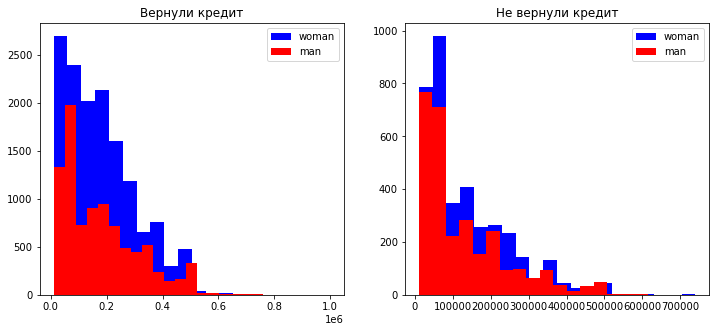

In [14]:
plt.figure(figsize(12, 5))
plt.subplot(1,2,1)
plt.hist(Vernul_Sex[Vernul_Sex['SEX'] == 2].LIMIT_BAL, bins = 20, color = 'b', label = 'woman')
plt.hist(Vernul_Sex[Vernul_Sex['SEX'] == 1].LIMIT_BAL, bins = 20, color = 'r', label = 'man')
plt.title('Вернули кредит')
plt.legend()

plt.subplot(1,2,2)
plt.hist(NeVernul_Sex[NeVernul_Sex['SEX'] == 2].LIMIT_BAL, bins = 20, color = 'b', label = 'woman')
plt.hist(NeVernul_Sex[NeVernul_Sex['SEX'] == 1].LIMIT_BAL, bins = 20, color = 'r', label = 'man')
plt.title('Не вернули кредит')
plt.legend()

plt.show()

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.
Построим доверительные интервалы для доли вернувших, не вернувших и для их разности.

In [15]:
from statsmodels.stats.proportion import proportion_confint

In [22]:
conf_interval_Vernul_m = proportion_confint(len(Vernul_Sex[Vernul_Sex['SEX'] == 1].SEX), 
                                            Vernul_Sex.shape[0],
                                            method = 'wilson')
conf_interval_Vernul_w = proportion_confint(len(Vernul_Sex[Vernul_Sex['SEX'] == 2].SEX), 
                                            Vernul_Sex.shape[0],
                                            method = 'wilson')
conf_interval_NeVernul_m = proportion_confint(len(NeVernul_Sex[NeVernul_Sex['SEX'] == 1].SEX), 
                                            NeVernul_Sex.shape[0],
                                            method = 'wilson')
conf_interval_NeVernul_w = proportion_confint(len(NeVernul_Sex[NeVernul_Sex['SEX'] == 2].SEX), 
                                            NeVernul_Sex.shape[0],
                                            method = 'wilson')

In [23]:
print('95%% доверительный интервал доли мужчин среди вернувших кредит: [%f, %f]' % conf_interval_Vernul_m)
print('95%% доверительный интервал доли женщин среди вернувших кредит: [%f, %f]' % conf_interval_Vernul_w)
print()
print('95%% доверительный интервал доли мужчин среди не вернувших кредит [%f, %f]' % conf_interval_NeVernul_m)
print('95%% доверительный интервал доли женщин среди не вернувших кредит [%f, %f]' % conf_interval_NeVernul_w)

95% доверительный интервал доли мужчин среди вернувших кредит: [0.379627, 0.392110]
95% доверительный интервал доли женщин среди вернувших кредит: [0.607890, 0.620373]

95% доверительный интервал доли мужчин среди не вернувших кредит [0.421062, 0.444898]
95% доверительный интервал доли женщин среди не вернувших кредит [0.555102, 0.578938]


Здесь мы можем видеть, что доверительные интервалы долей мужчин и женщин в группах вернувших кредит и невернувших кредит не пересекаются, следовательно гендерные составы групп различны.
Так же гипотезу о равенстве гендерного сотава этих групп мы можем проверить с помощью доверительного интервала для разности двух долей независимых выборок.

In [30]:
from scipy import stats

In [31]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

In [32]:
Sex_0 = scoring[scoring['default'] == 0].SEX.values
Sex_1 = scoring[scoring['default'] == 1].SEX.values

In [33]:
print('Доверительный интервал для разности выборок: [%f, %f]' % proportions_confint_diff_ind(np.abs(Sex_0-2), np.abs(Sex_1-2)))

Доверительный интервал для разности выборок: [-0.060548, -0.033635]


Используем статистический Z-критерий для доли для двух независимых выборок.
* H0: гендерный состав не отличается
* H1: гендерный состав отличается

In [34]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [35]:
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(Sex_0-2), np.abs(Sex_1-2))))

p-value: 0.000000000004473


Гипотеза о равенстве гендерного распределния отвергается. Данный результат явлется и практически значимым, т.к. 6% существенная величина для банков.

## 3.
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [36]:
# Приготовим выборки тех кто вернул кредит и тех кто не вернул кредит с учетом различий по образованию
Vernul_Edu = scoring[scoring['default'] == 0][['LIMIT_BAL',  'EDUCATION']]
NeVernul_Edu = scoring[scoring['default'] == 1][['LIMIT_BAL',  'EDUCATION']]

In [37]:
edu_dict = { 0: 'доктор',
            1: 'магистр',
            2: 'бакалавр',
            3: 'выпускник школы',
            4: 'начальное образование',
            5: 'прочее',
            6: 'нет данных'
           }

In [38]:
Vernul_Edu['Edu_name'] = Vernul_Edu.EDUCATION.apply(lambda x : edu_dict.get(x))
NeVernul_Edu['Edu_name'] = NeVernul_Edu.EDUCATION.apply(lambda x : edu_dict.get(x))

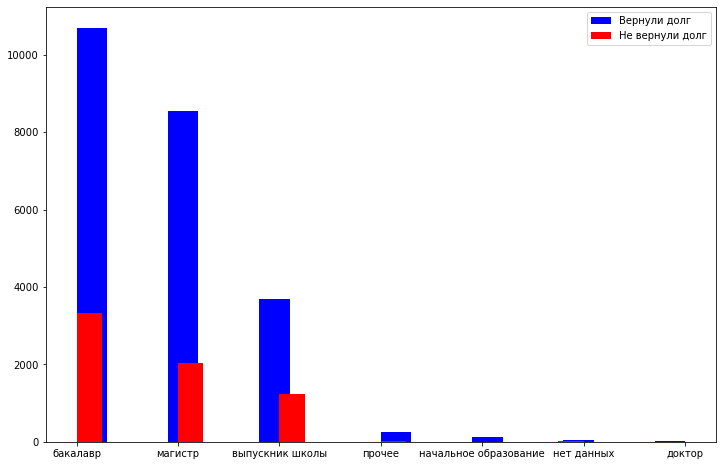

In [39]:
plt.figure(figsize(12, 8))
plt.hist(Vernul_Edu.Edu_name, bins = 20, color = 'b', label = 'Вернули долг')
plt.hist(NeVernul_Edu.Edu_name, bins = 20, color = 'r', label = 'Не вернули долг')
plt.legend()

plt.show()

В основном берут кредиты люди со степенью бакалавра и магистра. Принципиальная разница между распределниями тех, кто вернул, и тех, кто нет, не наблюдается.

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

Построим график долей возврата кредитов.

In [40]:
edu_table = pd.DataFrame(columns = ['Образование', 'Вернули', 'Не вернули'])
for i in range(7):
    edu_table.loc[i] = [edu_dict.get(i),
                            len(Vernul_Edu[Vernul_Edu['EDUCATION'] == i]), 
                            len(NeVernul_Edu[NeVernul_Edu['EDUCATION'] == i])]

In [41]:
edu_table = edu_table.set_index('Образование')
edu_table

,Вернули,Не вернули
Образование,,
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


In [44]:
line = edu_table['Вернули']/(edu_table['Вернули'] + edu_table['Не вернули'])

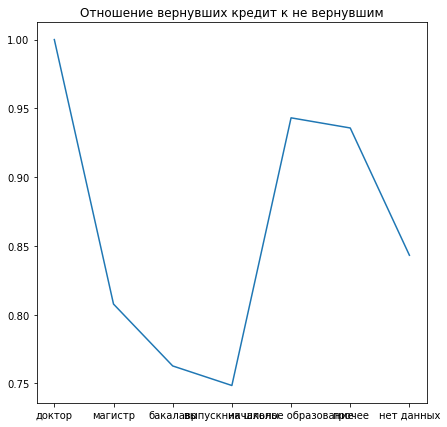

In [43]:
plt.figure(1, figsize=(7,7))
plt.title('Отношение вернувших кредит к не вернувшим')
plt.plot(line)
plt.show()

Исходя из графика видно, что распределние не является нормальным, следовательно, образование влияет на то, вернёт ли человек долг. Реже всего возвращают долги бакалавры и выпускники школ. Возвращают практически все долги только люди с докторской степенью.

Проверим на соответствие данного распределения нормальному с помощью критерия согласия Пирсона хи-квадрат.

* H0: рассматривая величина имеет равномерное распределение
* H1: H0 не верна 

Посчитаем среднее значение доли возврата кредитов среди различных уровней образования. Можно использовать эту оценку для построения ожидаемого нормального распределения.

In [47]:
line

Образование
доктор                          1
магистр                  0.807652
бакалавр                 0.762651
выпускник школы          0.748424
начальное образование    0.943089
прочее                   0.935714
нет данных               0.843137
dtype: object

In [48]:
mean_edu = np.mean(line)
print('Среднее значение отношения вернувших кредит к не вернувшим: %.2f' % mean_edu)

Среднее значение отношения вернувших кредит к не вернувшим: 0.86


Составим таблицу сопряжённости "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

In [61]:
edu_table['Ожидаемые'] = list(map(lambda x: int(round(x * mean_edu, 0)), edu_table['Вернули']+edu_table['Не вернули']))
edu_table['Разность'] = edu_table['Ожидаемые'] - edu_table['Вернули']
edu_table

,Вернули,Не вернули,Ожидаемые,Разность
Образование,,,,
доктор,14,0,12,-2
магистр,8549,2036,9134,585
бакалавр,10700,3330,12107,1407
выпускник школы,3680,1237,4243,563
начальное образование,116,7,106,-10
прочее,262,18,242,-20
нет данных,43,8,44,1


In [62]:
#chi-square criterion
stats.chisquare(edu_table['Вернули'], edu_table['Ожидаемые'], ddof = 1)

Power_divergenceResult(statistic=278.63624931992223, pvalue=3.907958481011075e-58)

Гипотеза о том, что величина имеет равномерное распределение отвергается с очень высокой долей вероятности.

Результат имеет практическую значимость для выдачи кредита, доли возврата значимо отличаются для разных уровней образования.

## 4.
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [63]:
# Приготовим выборки тех кто вернул кредит и тех кто не вернул кредит с учетом семейного положения
Vernul_Mar = scoring[scoring['default'] == 0][['LIMIT_BAL',  'MARRIAGE']]
NeVernul_Mar = scoring[scoring['default'] == 1][['LIMIT_BAL',  'MARRIAGE']]

In [64]:
mar_dict = {0: 'отказываюсь отвечать',
            1: 'замужем/женат',
            2: 'холост',
            3: 'нет данных'
           }

In [65]:
list(mar_dict.keys())

[0, 1, 2, 3]

In [66]:
Vernul_Mar['Mar_name'] = Vernul_Mar.MARRIAGE.apply(lambda x : mar_dict.get(x))
NeVernul_Mar['Mar_name'] = NeVernul_Mar.MARRIAGE.apply(lambda x : mar_dict.get(x))

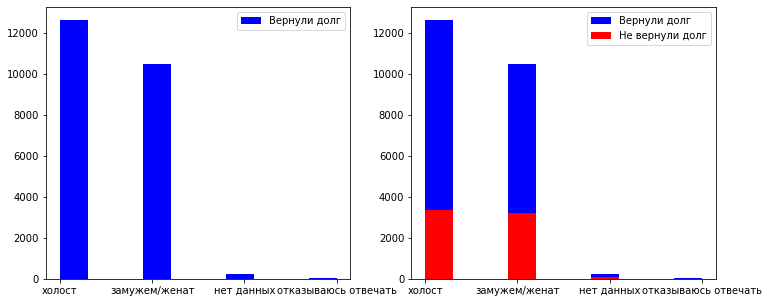

In [68]:
plt.figure(figsize(12, 5))
plt.subplot(1,2,1)
plt.hist(Vernul_Mar.Mar_name, color = 'b', label = 'Вернули долг')
plt.legend()

plt.subplot(1,2,2)
plt.hist(Vernul_Mar.Mar_name, color = 'b', label = 'Вернули долг')
plt.hist(NeVernul_Mar.Mar_name, color = 'r', label = 'Не вернули долг')
plt.legend()

plt.show()

Доли невозвратов среди женатых и холостых людей различается незначительно.

Проверим, как связан семейный статус с индикатором дефолта. Составим таблицу сопряженности

In [70]:
mar_table = pd.DataFrame(columns = ['Статус', 'Вернули', 'Не вернули'])
for i in range(4):
    mar_table.loc[i] = [mar_dict.get(i),
                        len(Vernul_Mar[Vernul_Mar['MARRIAGE'] == i]), 
                        len(NeVernul_Mar[NeVernul_Mar['MARRIAGE'] == i])]

In [71]:
mar_table = mar_table.set_index('Статус')
mar_table

,Вернули,Не вернули
Статус,,
отказываюсь отвечать,49,5
замужем/женат,10453,3206
холост,12623,3341
нет данных,239,84


Посчитаем коэффициент V Крамера.

In [74]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [77]:
print('Коэффициент V Cramer: %.4f' % cramers_stat(np.array(mar_table[['Вернули', 'Не вернули']])))

Коэффициент V Cramer: 0.0345


Коэффициент Крамера принимает значение, близкое к нулю, когда взаимосвязь отсутствует.

Практическая значимость в данном результате также присутствует, т.к. исходя из этих данных нет разницы в том, с каким статусом MARRIAGE приходит человек за кредитом.

## 5.
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [78]:
# Приготовим выборки тех кто вернул кредит и тех кто не вернул кредит с учетом возраста
Vernul_Age = scoring[scoring['default'] == 0][['LIMIT_BAL',  'AGE']]
NeVernul_Age = scoring[scoring['default'] == 1][['LIMIT_BAL',  'AGE']]

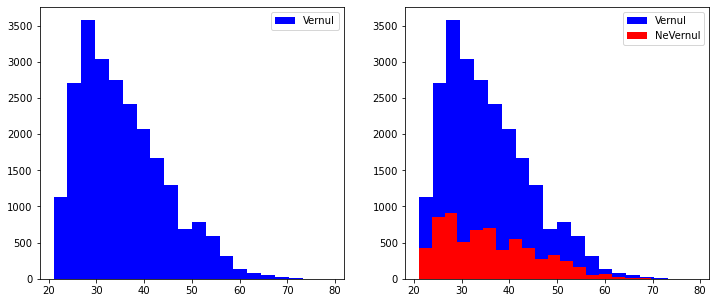

In [79]:
plt.figure(figsize(12, 5))
plt.subplot(1,2,1)
plt.hist(Vernul_Age.AGE, bins = 20, color = 'b', label = 'Vernul')
plt.legend()

plt.subplot(1,2,2)
plt.hist(Vernul_Age.AGE, bins = 20, color = 'b', label = 'Vernul')
plt.hist(NeVernul_Age.AGE, bins = 20, color = 'r', label = 'NeVernul')
plt.legend()

plt.show()

Среди не вернувших кредит больше молодых людей.

Проверим гипотезу о равенстве медианных значений возрастов с помощью подходящей интервальной оценки.

* H0: медианные значения равны
* H1: медианные значения отличаются

Доверительный интервал для медианы на основе бутстрепа.

In [80]:
np.random.seed(0)

Vernul_age_median_scores = list(map(np.median, get_bootstrap_samples(Vernul_Age.AGE.values, 1000)))
NeVernul_age_median_scores = list(map(np.median, get_bootstrap_samples(NeVernul_Age.AGE.values, 1000)))

print("95% доверительный итервал медианного значения возраста для вернувших кредит:",  stat_intervals(Vernul_age_median_scores, 0.05))
print("95% доверительный итервал медианного значения возраста лимита для невернувших кредит:",  stat_intervals(NeVernul_age_median_scores, 0.05))

95% доверительный итервал медианного значения возраста для вернувших кредит: [34. 34.]
95% доверительный итервал медианного значения возраста лимита для невернувших кредит: [34. 35.]


Как видно из интервальной оценки, интервальные оценки для медианы пересекаются.

Построим интервальную оценку для разности медиан.

In [83]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(Vernul_age_median_scores, NeVernul_age_median_scores)))

In [84]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% доверительный интервал для разности медиан: [%f, %f]' % (stat_int[0], stat_int[1]))

95% доверительный интервал для разности медиан: [0.000000, 1.000000]


Поскольку доверительный интервал содержит ноль, значения медиан не различаются.

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

* H0: распределения выборок полностью равны
* H1: распределения выборок отличаются на величину сдвига

In [85]:
print('p-value: %f' % permutation_test(Vernul_Age.AGE.values, NeVernul_Age.AGE.values, max_permutations=1000))

p-value: 0.014000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в распределениях видна невооружённым взглядом и эти данные могут учитываться при выдаче кредита.